In [1]:
!pip install transformers
!pip install pytorch-lightning
!pip install torchinfo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 60.1 MB/s eta 0:00:00


# Import lib

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import LayerNorm
from torch.nn import functional as F
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoTokenizer, AdamW, get_cosine_schedule_with_warmup
import numpy as np
import os
import time
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
import re
import copy
import nltk
from nltk.tokenize import word_tokenize
import math
from torchinfo import summary
from google.colab import drive
from tqdm.auto import tqdm
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Import dataset

In [3]:
! git clone https://github.com/duongnghia222/News_classification

Cloning into 'News_classification'...
remote: Enumerating objects: 457, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 457 (delta 27), reused 39 (delta 14), pack-reused 402
Receiving objects: 100% (457/457), 104.26 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (265/265), done.
Updating files: 100% (55/55), done.


In [4]:
# Load data from CSV file
df = pd.read_csv('News_classification/data/raw_data/raw_data.csv', encoding='utf-8-sig')

# Visualize Data

In [5]:
df.tail()

,Content,Label
10391,"Một cá nhân bất ngờ mua vào 30,77 triệu cổ phi...",TTF
10392,"Chưa kịp bán ra, Chủ tịch Đỗ Quý Hải tiếp tục ...",HPX
10393,POM cho cán bộ nhân viên nghỉ việc vì dừng lò ...,POM
10394,Năm Bảy Bảy (NBB) chấp thuận cho Công ty con c...,NBB
10395,Chứng khoán Ngân hàng Sài Gòn Thương Tín (SBS)...,SBS


In [6]:
# Count the number of words in each article's content and number of times a class appear
df['Word Count'] = df['Content'].apply(lambda x: len(str(x).split()))
df['Class Count'] = df.groupby('Label')['Label'].transform('count')

# Calculate statistics for word count
df['Word Count'].describe()

count    10396.000000
mean       607.325414
std        352.123889
min         46.000000
25%        381.000000
50%        514.000000
75%        725.250000
max       4235.000000
Name: Word Count, dtype: float64

In [7]:
df.head()

,Content,Label,Word Count,Class Count
0,"Vingroup báo lãi hơn 3.600 tỷ đồng, doanh thu ...",VIC,599,108
1,HAGL Agrico (HNG) lỗ quý thứ 5 liên tiếp. Giá ...,HNG,642,65
2,"Vingroup lãi ròng 1.028 tỷ đồng nửa đầu năm, t...",VIC,577,108
3,Một doanh nghiệp khoáng sản đã vượt 153% mục t...,KSV,430,3
4,Doanh nghiệp thép từ lớn đến nhỏ đều báo lỗ qu...,HPG,1247,197


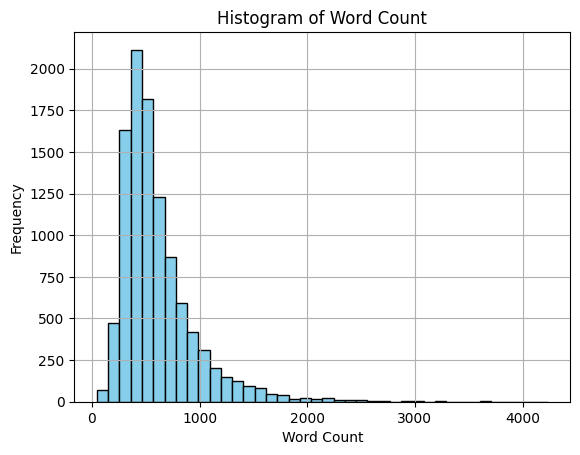

In [8]:
# Plot histogram for word count
plt.hist(df['Word Count'], bins=40, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [9]:
# Count the occurrence of each unique label
label_counts = df['Label'].value_counts()
print(label_counts.describe())

# Loop over each unique label and print its count
# for label, count in label_counts.items():
#     print(f"Label: {label}, Count: {count}")

count    927.000000
mean      11.214671
std       21.224713
min        1.000000
25%        1.000000
50%        3.000000
75%       11.000000
max      197.000000
Name: Label, dtype: float64


## Extract Dataset

In [10]:
# extracted_df
e_df = df.loc[df['Class Count'] > 17].sort_values(by="Class Count", ascending=False)
e_df.count()

Content        7256
Label          7256
Word Count     7256
Class Count    7256
dtype: int64

In [11]:
number_of_classes = e_df['Label'].nunique()
number_of_classes

156

# Processing Dataset

## Clean text

In [12]:
with open('/content/News_classification/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = f.read().splitlines()

vietnamese_stopwords[:10]

['a lô',
 'a ha',
 'ai',
 'ai ai',
 'ai nấy',
 'ai đó',
 'alô',
 'amen',
 'anh',
 'anh ấy']

In [13]:
def clean_text(txt):
    txt = re.sub('\s+', ' ', txt)
    txt = txt.replace('.','')
    txt = re.sub('\n', ' ', txt)
    txt = [word_tokenize(wrd) for wrd in txt.split() if wrd not in vietnamese_stopwords]
    txt = [item[0] for item in txt]
    txt = ' '.join(txt)
    return txt

clean_text(" VinFast chính thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S tại 24 tỉnh, thành phố trên cả nước")

'VinFast thức vận hành 35 showroom xe máy điện kết hợp trung tâm trải nghiệm Vin3S 24 tỉnh thành phố'

In [14]:
# e_df['Content'] = e_df['Content'].apply(clean_text)
e_df.head()

,Content,Label,Word Count,Class Count
979,Hòa Phát muốn đầu tư loạt dự án rộng hơn 1.500...,HPG,950,197
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197
1256,Hòa Phát lên lịch tổ chức đại hội cổ đông 2022...,HPG,598,197
3787,Hòa Phát đã khắc phục xong sự cố hỏa hoạn tại ...,HPG,271,197
3771,Hòa Phát tiết kiệm 1.700 tỷ đồng trong 6 tháng...,HPG,601,197


## Transform labels

In [15]:
labels_list = e_df['Label'].tolist()
print(labels_list[:10])

['HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG', 'HPG']


In [16]:
le = LabelEncoder()
labels = le.fit_transform(labels_list).tolist()
print(labels[-10:])

[142, 31, 142, 128, 90, 73, 101, 90, 90, 142]


In [17]:
e_df['Encode Label'] = labels
e_df.head(10)

,Content,Label,Word Count,Class Count,Encode Label
979,Hòa Phát muốn đầu tư loạt dự án rộng hơn 1.500...,HPG,950,197,55
3878,Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Kh...,HPG,425,197,55
1256,Hòa Phát lên lịch tổ chức đại hội cổ đông 2022...,HPG,598,197,55
3787,Hòa Phát đã khắc phục xong sự cố hỏa hoạn tại ...,HPG,271,197,55
3771,Hòa Phát tiết kiệm 1.700 tỷ đồng trong 6 tháng...,HPG,601,197,55
1278,Tham vọng làm dự án thép công suất 80% Hoà Phá...,HPG,1135,197,55
1287,Những doanh nhân tuổi Sửu nổi bật trên thương ...,HPG,1253,197,55
3725,"Hòa Phát lãi kỷ lục, ban lãnh đạo sắp được thư...",HPG,573,197,55
3685,"Ông Nguyễn Việt Thắng, tân Tổng Giám đốc Tập đ...",HPG,135,197,55
7763,Hòa Phát đã bán 530 ngàn tấn thép trong tháng ...,HPG,303,197,55


## Split trainset valset

In [18]:
trainset, valset = train_test_split(e_df, test_size=0.2, stratify=e_df['Encode Label'])
print(len(trainset))
trainset = trainset.drop_duplicates(subset=['Label', 'Word Count'], keep='first')
print(len(trainset))
trainset['Class Count'] = trainset.groupby('Label')['Label'].transform('count')
valset['Class Count'] = valset.groupby('Label')['Label'].transform('count')
print("How many unique labels in the trainset", trainset['Encode Label'].nunique())
print("How many unique labels in the valset", valset['Encode Label'].nunique())

5804
5469
How many unique labels in the trainset 156
How many unique labels in the valset 156


In [19]:
trainset_unique_label = trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")
trainset_unique_label.head()


,Content,Label,Word Count,Class Count,Encode Label
9037,OCH làm rõ lý do về quyết định xử phạt vi phạm...,OCH,556,12,90
4534,Vinatex chốt quyền trả cổ tức 5% bằng tiền. Vớ...,VGT,217,14,142
2913,"Pomina chuyển từ lãi sang lỗ sau soát xét, kiể...",POM,369,15,101
8411,"CIC Group (CKG): Lãnh đạo chỉ mua được 29,3% t...",CKG,329,15,17
4744,Dragon Capital buộc phải bán cổ phần Imexpharm...,IMP,779,15,66


In [20]:
trainset.to_csv("trainset.csv", index=False, encoding='utf-8-sig')

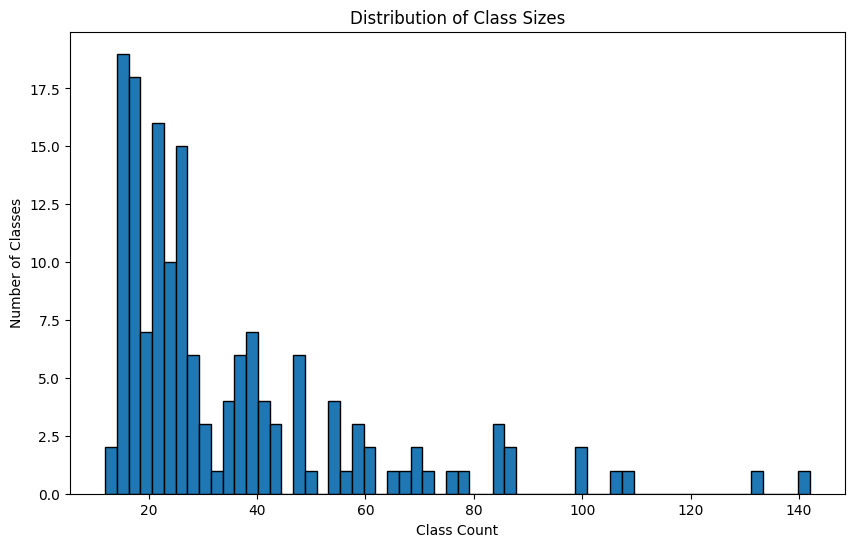

In [21]:
plt.figure(figsize=(10,6))
plt.hist(trainset_unique_label['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()


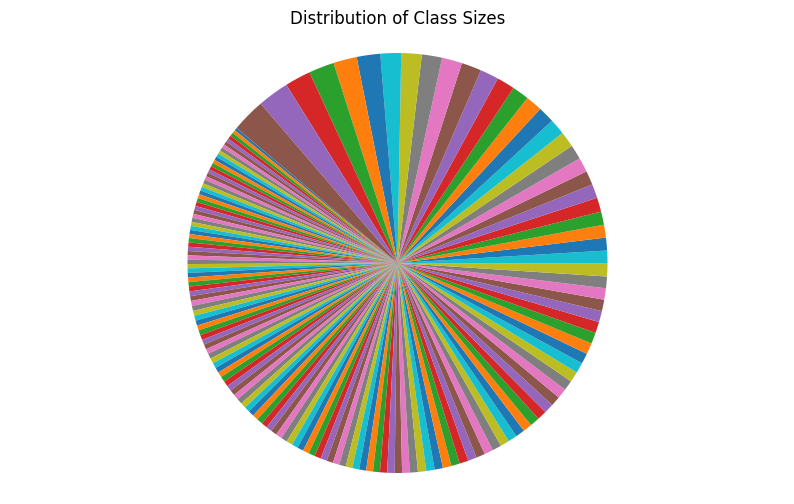

In [22]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
sizes = trainset_unique_label['Class Count'].values

plt.figure(figsize=(10,6))
plt.pie(sizes, startangle=140)
plt.title('Distribution of Class Sizes')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Balance Dataset

In [23]:
def balance_data(df, target_count, max_length):
    balanced_df = pd.DataFrame(columns=df.columns)
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label]
        count = len(label_df)

        if count >= target_count:
            label_df = label_df.sample(n=target_count, random_state=42)
        else:
            additional_samples_needed = target_count - count
            samples_per_row = (additional_samples_needed // count)
            additional_samples = []

            for _, row in label_df.iterrows():
                content = row['Content']
                sentences = nltk.tokenize.sent_tokenize(content)

                window_start = 0

                for _ in range(samples_per_row):
                    picked_sentences = []
                    word_count = 0
                    i = window_start  # Set i to the start of the current window

                    while i < len(sentences):
                        sentence = sentences[i]
                        sentence_word_count = len(sentence.split())

                        if word_count + sentence_word_count > max_length:
                            break

                        picked_sentences.append(sentence)
                        word_count += sentence_word_count
                        i += 1

                    # No need to remove picked sentences from the list

                    if len(picked_sentences) > 0:
                        new_sample = pd.Series(data=copy.deepcopy(row.values), index=df.columns)
                        new_sample['Content'] = ' '.join(picked_sentences)
                        additional_samples.append(new_sample)

                    # Slide the window by one sentence
                    if window_start + 1 < len(sentences):
                        window_start += 1
                    else:
                        break  # Break the loop if we've processed all sentences

            # This is a new block of code to limit the number of samples
            # We randomly select 'target_count' samples if there are more than 'target_count' samples
            if len(additional_samples) > target_count:
                additional_samples = random.sample(additional_samples, target_count)

            additional_samples = pd.DataFrame(additional_samples)
            label_df = pd.concat([label_df, additional_samples], ignore_index=True)

        balanced_df = pd.concat([balanced_df, label_df], ignore_index=True)

    return balanced_df


In [24]:
balanced_trainset = balance_data(trainset, target_count=50, max_length=150)

In [25]:
balanced_trainset['Class Count'] = balanced_trainset.groupby('Label')['Label'].transform('count')
# df['Word Count'] = balanced_trainset['Content'].apply(lambda x: len(str(x).split()))
balanced_trainset.head()

,Content,Label,Word Count,Class Count,Encode Label
0,Lộ diện nhiều doanh nghiệp tăng trưởng lợi nhu...,AAA,1285,41,0
1,SSI Research: AAA chờ nguồn thu từ khu công ng...,AAA,473,41,0
2,"AAA lãi quý II tăng 25%, thực hiện 33% kế hoạc...",AAA,561,41,0
3,"AAA được mở room ngoại lên 100%. Mới đây, CTCP...",AAA,331,41,0
4,AAA báo lãi sau thuế quý 2 hơn 92 tỷ đồng. CTC...,AAA,420,41,0


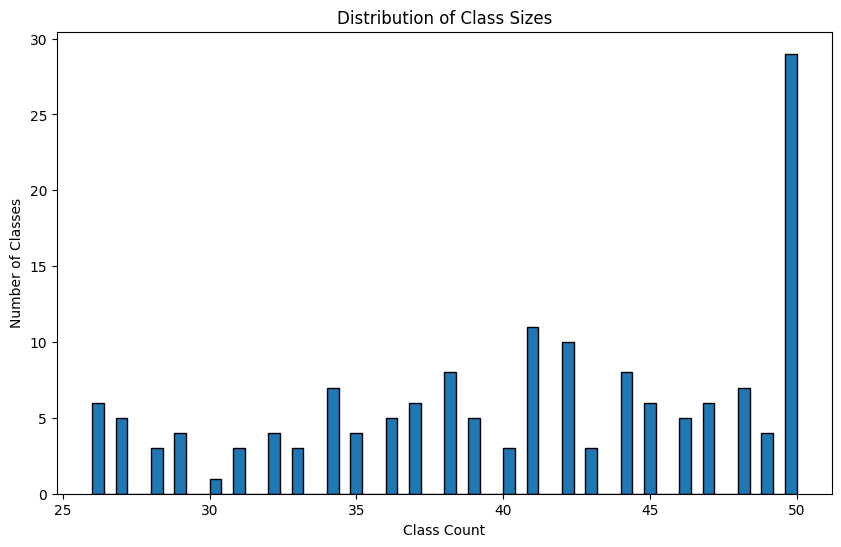

In [26]:
plt.figure(figsize=(10,6))
plt.hist(balanced_trainset.drop_duplicates(subset='Encode Label').sort_values(by="Class Count")['Class Count'], bins=60, edgecolor='black')
plt.title('Distribution of Class Sizes')
plt.xlabel('Class Count')
plt.ylabel('Number of Classes')
plt.show()

# Load phoBERT tokenizer

In [27]:
# Load pre-trained tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [28]:
text = "công tyNếu tính GJK"
print(tokenizer.encode(text))
text = "công ty Nếu tính gjk"
print(tokenizer.encode(text))

[0, 675, 6745, 313, 294, 1276, 2136, 2260, 2]
[0, 675, 6892, 313, 294, 1529, 57202, 2]


# Hyperparameters


In [29]:
MAX_LENGTH = 256  # Adjust as needed
BATCH_SIZE = 32
N_CLASSES = number_of_classes  # Replace with your actual number of classes
EPOCHS = 30

# ArticleDataset Class

In [30]:
class ArticleDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length=256):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        label = item.get('Encode Label')
        encoding = self.tokenizer.encode_plus(
            text=item.Content,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'content': item.Content,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



In [31]:
x = torch.tensor([1, 2, 3, 4, 5])
print(x.shape)

torch.Size([5])


In [32]:
a_ds = ArticleDataset(balanced_trainset, labels, tokenizer, MAX_LENGTH)
random_index = random.randint(0, len(a_ds) - 1)  # Generate a random index within the valid range
sample_item = a_ds[random_index]
print(len(a_ds))
print(sample_item.keys())
print(sample_item['content'])

6356
dict_keys(['content', 'input_ids', 'attention_mask', 'labels'])
Vinaconex sau một năm đổi… mẹ. Cổ đông lớn nhất và cũng là công ty mẹ của Tổng CTCP Xuất nhập khẩu và Xây dựng Việt Nam (Vinaconex, HOSE: VCG) là CTCP Đầu tư Pacific Holdings - một doanh nghiệp thành lập từ cuối năm 2021. Sau một năm đổi chủ, dù không khác về bản chất, Vinaconex vẫn kết thúc năm cũ theo cách tương đối suôn sẻ.    Hành trình đổi “mẹ” của Vinaconex Đầu năm 2022, Vinaconex bất ngờ đổi cổ đông lớn. Chính xác là vào ngày 23/02/2022, CTCP Đầu tư Pacific Holdings (gọi tắt là Pacific Holdings) nhận chuyển nhượng toàn bộ hơn 277.8 triệu cp từ Công ty TNHH An Quý Hưng, qua đó nâng tỷ lệ sở hữu từ 0% lên 62.9%, trở thành Công ty mẹ của Vinaconex.  Chuyện doanh nghiệp đổi chủ không có gì lạ, nhưng câu chuyện của Pacific Holdings thì có. Ngay từ ngày mới thành lập 12/11/2021, Pacific Holdings ghi nhận mức vốn điều lệ khủng 7.1 ngàn tỷ đồng. Tân binh có hơn 130 ngành nghề đăng ký kinh doanh, song, hoạt động chính t

In [33]:
print(sample_item["input_ids"].shape)
print(tokenizer.decode(sample_item['input_ids']))
print(sample_item["labels"])
print(le.inverse_transform([sample_item["labels"]]))

torch.Size([256])
<s> Vinaconex sau một năm đổi… mẹ. Cổ đông lớn nhất và cũng là công ty mẹ của Tổng CTCP Xuất nhập khẩu và Xây dựng Việt Nam (Vinaconex, HOSE: VCG) là CTCP Đầu tư Pacific Holdings - một doanh nghiệp thành lập từ cuối năm 2021. Sau một năm đổi chủ, dù không khác về bản chất, Vinaconex vẫn kết thúc năm cũ theo cách tương đối suôn sẻ. Hành trình đổi “mẹ” của Vinaconex Đầu năm 2022, Vinaconex bất ngờ đổi cổ đông lớn. Chính xác là vào ngày 23/02/2022, CTCP Đầu tư Pacific Holdings (gọi tắt là Pacific Holdings) nhận chuyển nhượng toàn bộ hơn 277.8 triệu cp từ Công ty TNHH An Quý Hưng, qua đó nâng tỷ lệ sở hữu từ 0% lên 62.9%, trở thành Công ty mẹ của Vinaconex. Chuyện doanh nghiệp đổi chủ không có gì lạ, nhưng câu chuyện của Pacific Holdings thì có. Ngay từ ngày mới thành lập 12/11/2021, Pacific Holdings ghi nhận mức vốn điều lệ khủng 7.1 ngàn tỷ đồng. Tân binh có hơn 130 ngành nghề đăng ký kinh doanh, song, hoạt động chính trong lĩnh vực kinh doanh bất động sản. Sau ba tháng

# Pytorch Lightning DataModule

In [34]:
class Data_Module(pl.LightningDataModule):
    def __init__(self, trainset, valset, labels, batch_size: int = 32, max_token_length: int = 256, tokenizer=None):
      super().__init__()
      self.trainset = trainset
      self.val_path = valset
      self.labels = labels
      self.batch_size = batch_size
      self.max_token_length = max_token_length
      self.tokenizer = tokenizer

    def setup(self, stage = None):
      if stage in (None, "fit"):
        self.train_dataset = ArticleDataset(self.trainset, self.labels, self.tokenizer, self.max_token_length)
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)
      if stage == 'predict':
        self.val_dataset = ArticleDataset(self.val_path, self.labels, self.tokenizer, self.max_token_length)

    def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size = self.batch_size, num_workers=2, shuffle=True)

    def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

    def predict_dataloader(self):
      return DataLoader(self.val_dataset, batch_size = self.batch_size, num_workers=2, shuffle=False)

# Create PyTorch lightning DataLoader

In [35]:
# Create PyTorch lightning DataLoader
data_loader = Data_Module(balanced_trainset, valset, labels, BATCH_SIZE, MAX_LENGTH, tokenizer)
data_loader.setup()
len(data_loader.train_dataloader())

199

# Model architecture

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
class ArticleClassifier(pl.LightningModule):
    def __init__(self, config: dict, freeze_bert=False):
        super().__init__()
        self.config = config
        self.bert = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        print(self.bert.config.hidden_size)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 128)  # Adjusted the input size to match the bert's hidden size
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.layer_norm = LayerNorm(256)
        self.output = nn.Linear(256, self.config['n_labels'])
        self.loss = nn.CrossEntropyLoss()



    def forward(self, input_ids, attention_mask):
        x = self.bert(input_ids, attention_mask).pooler_output
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.layer_norm(x)
        logits = self.output(x)  # Remove softmax activation here
        return logits

# Initialize Model

## Model configuration

In [40]:
config = {
    'model_name': 'vinai/phobert-base-v2',
    'n_labels': number_of_classes,
    'batch_size': BATCH_SIZE,
    'lr': 1e-3,
    'warmup': 0.15,
    'train_size': len(data_loader.train_dataloader()),
    'weight_decay': 0.01,
    'n_epochs': 100
}

## Create model

In [41]:
# Initialize our classifier
model = ArticleClassifier(config, freeze_bert=True)
model = model.to(device)

Some weights of the model checkpoint at vinai/phobert-base-v2 were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


768


In [42]:
idx=0
input_ids_ = a_ds.__getitem__(idx)['input_ids']
attention_mask_ = a_ds.__getitem__(idx)['attention_mask']
labels_ = a_ds.__getitem__(idx)['labels']
model.cpu()
output = model(input_ids_.unsqueeze(dim=0), attention_mask_.unsqueeze(dim=0))
print(labels_.shape, output.shape)

torch.Size([]) torch.Size([1, 156])


In [43]:
test_batch = next(iter(data_loader.train_dataloader()))
test_batch_input_ids = test_batch['input_ids']
print(test_batch_input_ids.shape)
output = model(test_batch['input_ids'], test_batch['attention_mask'])
print(labels_.shape, output.shape)

torch.Size([32, 256])
torch.Size([]) torch.Size([32, 156])


In [44]:
test_batch_labels = test_batch['labels']
test_batch_labels.shape

torch.Size([32])

# Model Summary

In [45]:
summary(model)

Layer (type:depth-idx)                                       Param #
ArticleClassifier                                            --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (49,152,768)
│    │    └─Embedding: 3-2                                   (198,144)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Linear: 1-2                                            


# Train Model

In [46]:
def train_model(model, data_loader, config):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    total_steps = config['train_size']/config['batch_size']
    warmup_steps = math.floor(total_steps * config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    best_valid_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_limit = 5  # Number of epochs with no improvement after which training will be stopped
    model_path = 'best_model.pt'  # path where best model will be saved

    progress_bar = tqdm(range(config['n_epochs']), desc="Training", total=config['n_epochs'])

    for epoch in progress_bar:
        start_time = time.time()  # start time of the epoch

        model.train()
        total_loss = 0

        train_predictions , train_true_labels = [], []

        for batch in data_loader.train_dataloader():
            optimizer.zero_grad()

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store train predictions and true labels for accuracy calculation
            train_predictions.append(logits)
            train_true_labels.append(labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(data_loader.train_dataloader())

        # Calculate training accuracy
        train_predictions = np.concatenate(train_predictions, axis=0)
        train_true_labels = np.concatenate(train_true_labels, axis=0)
        train_accuracy = accuracy_score(train_true_labels, np.argmax(train_predictions, axis=1))

        # Start the validation
        model.eval()

        predictions , true_labels = [], []
        total_eval_loss = 0

        for batch in data_loader.val_dataloader():
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            with torch.no_grad():
                logits = model(input_ids, attention_mask)

            loss = model.loss(logits, labels)
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            labels = labels.to('cpu').numpy()

            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(labels)

        # Calculate the average loss over all of the batches
        avg_val_loss = total_eval_loss / len(data_loader.val_dataloader())

        # Calculate validation accuracy
        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.concatenate(true_labels, axis=0)
        val_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

        end_time = time.time()  # end time of the epoch
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)  # calculate elapsed time for this epoch

        # Print additional information after each epoch
        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {avg_train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}% | Valid Loss: {avg_val_loss:.3f} | Valid Acc: {val_accuracy*100:.2f}%')

        # Update progress bar
        progress_bar.set_postfix({'train_loss': avg_train_loss, 'valid_loss': avg_val_loss, 'valid_acc': val_accuracy, 'train_acc': train_accuracy})

        # save model if validation loss has decreased
        if avg_val_loss < best_valid_loss:
            best_valid_loss = avg_val_loss
            torch.save(model.state_dict(), model_path)
            early_stopping_counter = 0  # reset counter
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_limit:
                print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_limit}')
                if early_stopping_counter >= early_stopping_limit:
                    print('Early stopping, stopping training')
                    break  # break out from the training loop


In [47]:
train_model(model, data_loader, config)

Training:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 01 | Time: 0.0m 27.60950207710266s
	Train Loss: 5.135 | Train Acc: 0.96% | Valid Loss: 4.946 | Valid Acc: 2.00%

Epoch: 02 | Time: 0.0m 26.863948345184326s
	Train Loss: 4.948 | Train Acc: 2.01% | Valid Loss: 4.486 | Valid Acc: 6.13%

Epoch: 03 | Time: 0.0m 26.818441152572632s
	Train Loss: 4.547 | Train Acc: 5.82% | Valid Loss: 3.865 | Valid Acc: 16.39%

Epoch: 04 | Time: 0.0m 26.829428911209106s
	Train Loss: 4.151 | Train Acc: 9.83% | Valid Loss: 3.490 | Valid Acc: 21.01%

Epoch: 05 | Time: 0.0m 26.83958888053894s
	Train Loss: 3.807 | Train Acc: 13.77% | Valid Loss: 3.070 | Valid Acc: 26.17%

Epoch: 06 | Time: 0.0m 26.86101794242859s
	Train Loss: 3.586 | Train Acc: 17.09% | Valid Loss: 2.877 | Valid Acc: 30.10%

Epoch: 07 | Time: 0.0m 26.86475706100464s
	Train Loss: 3.389 | Train Acc: 19.65% | Valid Loss: 2.509 | Valid Acc: 39.05%

Epoch: 08 | Time: 0.0m 26.86891007423401s
	Train Loss: 3.262 | Train Acc: 22.28% | Valid Loss: 2.359 | Valid Acc: 42.08%

Epoch: 09 | Time: 0.0m 26.

# Predict

In [48]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [49]:
def test_model(model, data_loader):
    # model.load_state_dict(torch.load('best_model.pt'))
    model.eval()

    predictions, true_labels = [], []
    cnt = 0
    for batch in data_loader.val_dataloader():
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            logits = model(input_ids, attention_mask)

        logits = logits.detach().cpu().numpy()
        labels = labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(labels)
        if cnt < 1:
          for i in range(BATCH_SIZE):
            print(f"Content: {batch['content'][i]}")
            print(f"Predicted Label: {le.inverse_transform([np.argmax(logits, axis=1)[i]])}")
            print(f"True Label: {le.inverse_transform([labels[i]])}")
            print("========================================")

        cnt += 1

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)

    # Calculate accuracy
    test_accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

    print(f'Test Accuracy: {test_accuracy}')

    return test_accuracy

In [50]:
test_model(model, data_loader)

Content: PNJ lãi sau thuế hơn 1,600 tỷ đồng sau 11 tháng, gần gấp đôi cùng kỳ. Theo báo cáo cập nhật kết quả kinh doanh, tháng 11, CTCP Vàng bạc Đá quý Phú Nhuận (HOSE: PNJ) ghi nhận doanh thu thuần 2,529 tỷ đồng và lãi sau thuế 152 tỷ đồng, tăng lần lượt 16.8% và 8.4% so với cùng kỳ. Lãi sau thuế 11 tháng đạt gần 1,640 tỷ đồng, vượt 24% kế hoạch lợi nhuận năm. PNJ cho biết kết quả tăng trưởng trên đạt được trong bối cảnh sức mua chung của các ngành bán lẻ có dấu hiệu chậm lại. Tuy nhiên, Công ty tiếp tục duy trì các nỗ lực tối ưu hóa doanh thu, lợi nhuận và chuẩn bị cho mùa Giáng sinh và Tết.    Lũy kế 11 tháng năm 2022, PNJ thu về 31,063 tỷ đồng doanh thu thuần và 1,639 tỷ đồng lợi nhuận sau thuế, tăng lần lượt 85.4% và 96.1% so với cùng kỳ năm 2021. Bóc tách cơ cấu doanh thu, doanh thu bán lẻ 11 tháng tăng  92.3% so với cùng kỳ (chiếm 60.7% tổng doanh thu); doanh thu sỉ tăng 71.6% (chiếm 12.2%); doanh thu vàng 24K tăng 84.8% (chiếm 25.6%), còn lại là doanh thu khác (chiếm 1.5%).
 Kỳ

0.6797520661157025

# Naive Bayes

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [52]:
test_content = e_df.iloc[1].get("Content")
print(test_content)
print("------------------------------------------------------------")
sentences = nltk.tokenize.sent_tokenize(test_content)
for s in sentences:
  print(s)

Hòa Phát muốn rót 85.000 tỷ đồng để mở rộng Khu liên hợp Dung Quất. Tập đoàn Hòa Phát (Mã: HPG) dự kiến sẽ đầu tư thêm 85.000 tỷ đồng vào Khu liên hợp tại Dung Quất, tăng 25.000 tỷ so với ước tính trước đó. Tập đoàn Hòa Phát định rót thêm 85.000 tỷ đồng vào Dung Quất. (Ảnh minh họa: Song Ngọc). Hội đồng quản trị Tập đoàn Hòa Phát dự kiến sẽ trình đại hội cổ đông thường niên 2021 thông qua kế hoạch đầu tư Khu liên hợp sản xuất Gang thép Hòa Phát Dung Quất giai đoạn 2.  Cụ thể, công suất hàng năm dự kiến là 5,6 triệu tấn, trong đó thép dẹt là 4,6 triệu tấn và thép thanh, thép dây chất lượng cao là 1 triệu tấn. Tổng mức đầu tư ước tính khoảng 85.000 tỷ đồng, trong đó vốn cố định là 70.000 tỷ đồng, vốn lưu động 15.000 tỷ. Hòa Phát dự tính sẽ xây dựng hoàn thành và đưa dự án vào hoạt động trong thời hạn 36 tháng kể từ ngày bàn giao đất và cấp giấy phép xây dựng. Tổng diện tích đất dự kiến sử dụng là 283,73 ha. Quy mô dự án đề xuất đợt này đã tăng đáng kể so với kế hoạch mà đại hội cổ đông n

In [53]:
train_data, test_data, train_labels, test_labels = train_test_split(e_df['Content'], e_df['Encode Label'], random_state=42)

In [54]:
model_nb = make_pipeline(CountVectorizer(), MultinomialNB())

In [55]:
# Train the model
model_nb.fit(train_data, train_labels)


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [56]:
# Predict the labels of the test set
predictions = model_nb.predict(test_data)

# Print out the accuracy
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")

Accuracy: 0.6251378169790518
